In [36]:
import json
import re
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

with open('perguntas.json','r',encoding='utf-8') as f:
    perguntas = json.load(f)

with open('embeddings.json','r',encoding='utf-8') as f:
    embeddings = json.load(f)

In [3]:
def clean(pergunta):
    return re.sub(r'[^a-z\sáéíóúâêôãõàç-]','',pergunta.lower()).replace('-',' ')

def embed(sentences):
    return model.encode(sentences)

In [4]:
words = 0
for perg in perguntas:
    art = perg['artigo']
    cleaned = clean(art)[3:].strip()
    words += len(cleaned.split())

words / len(perguntas)

45.14265060240964

In [5]:
comb = list(combinations(np.arange(len(embeddings)),2))
df = pl.DataFrame({'a':[c[0] for c in comb],'b':[c[1] for c in comb]})

In [6]:
arts = [clean(point['artigo']) for point in perguntas]
art_embeds = embed(arts)

In [7]:
dists = []
for a,b in df.iter_rows():
    artA = art_embeds[a].reshape(1, -1)
    artB = art_embeds[b].reshape(1, -1)
    dists.append(cosine_similarity(artA,artB))
    print(a,end = '\r')

In [16]:
distancias = np.array([d[0][0] for d in dists])

In [19]:
df = df.with_columns(
    cossine = distancias,
    dist = (pl.col('a') - pl.col('b')).abs()
)

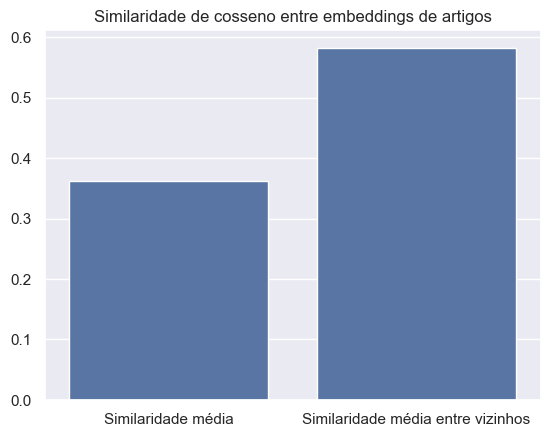

In [35]:
sim_media = df.get_column('cossine').mean()
sim_vizinhos = (
    df.filter(pl.col('dist') == 1)
    .get_column('cossine')
    .mean()
)

sns.set_theme(style="darkgrid")
sns.barplot(x=['Similaridade média','Similaridade média entre vizinhos'], y=[sim_media,sim_vizinhos])
plt.title('Similaridade de cosseno entre embeddings de artigos')
plt.savefig('similaridade.svg',format='svg')
plt.show()

In [54]:
frases = ['quantos anos você tem','qual é a sua idade','em qual ano você nasceu','vai chover amanhã']
embeds = embed(frases)
demb = {f:emb for f,emb in zip(frases,embeds)}

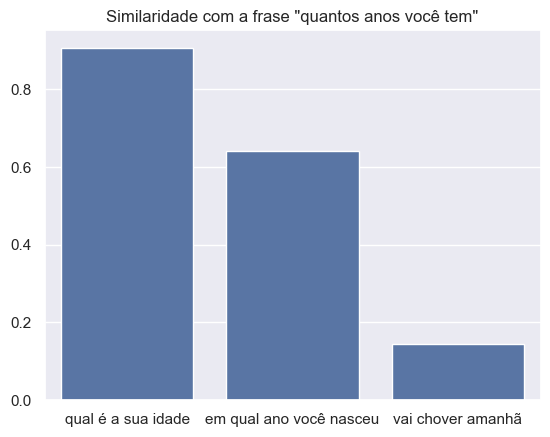

In [59]:
dists = [cosine_similarity(demb[frases[0]].reshape(1,-1),demb[f].reshape(1,-1))[0][0] for f in frases[1:]]

sns.barplot(x=frases[1:], y=dists)
plt.title('Similaridade com a frase "quantos anos você tem"')
plt.savefig('sim_anos.svg',format='svg')
plt.show()

In [3]:
import json
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [12]:
with open('embeddings.json','r',encoding = 'utf-8') as f:
    data = json.load(f)

embeds = []
for point in data:
    embeds += list(point['embeddings'].values())

arr = np.array(embeds)
nbrs = NearestNeighbors(n_neighbors = 5,metric='cosine').fit(arr)

In [8]:
nbrs.get_metadata_routing()

{}